# Downloading and Plotting River Gauge Data
## Written By Jared Rennie (@jjrennie)

Taps into APIs to get river gauge data and metadata. Two public API's are used. The first is the National Weather Service's <a href='https://water.noaa.gov' target="_blank">National Water Prediction System (NWPS)</a>, and the second is the US Geological Survey's <a href='https://waterdata.usgs.gov/nwis?' target='_blank'>National Water Information System (NWIS)</a>. Note that data in NWPS is only for the last 30 days, so NWIS is also used to get historical data.

- NWPS API Documentation: https://api.water.noaa.gov/nwps/v1/docs/#/Gauges/Gauges_ListGauges
- NWIS API Documentation: https://waterservices.usgs.gov/

### What You Need

First off, the entire codebase works in Python 3. In addition to base Python, you will need the following packages installed: 
- <a href='https://github.com/DOI-USGS/dataretrieval-python' target="_blank">dataretrieval-python</a> (aquire data from nwis)
- pandas and numpy (to slice and dice the data)
- matplotlib and cartopy (to plot the data)
    
The "easiest" way is to install these is by installing <a href='https://www.anaconda.com' target="_blank">anaconda</a>, and then applying <a href='https://conda-forge.org/' target="_blank">conda-forge</a>. Afterward, then you can install the above packages. 

### Importing Packages
Assuming you did the above, it should (in theory) import everything no problem:

In [1]:
# Import Packages
%matplotlib inline
import json,requests,sys,datetime,pytz
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

from dataretrieval import nwis

print("SUCCESS!")

SUCCESS!


If you made it this far, great! 

## Get Metadata from NWPS API
The metadata provided in the National Weather Service API (NWPS) has additional metadata features not provided elsewhere, including categorical flooding information, and historical crest information. So we will start there.

We need a station identifier to start, you can find stations by going to https://water.noaa.gov and picking a station. We will use a station in Fletcher, North Carolina (FLCN7) as an example.

And finally we need to give you credit for the images that are created later on!

In [2]:
# Input Arguments Here
stationID='FLCN7' 
author='Not Jared Rennie' 

The next block of code will grab the metadata from the API. The request comes out as JSON, so some parsing is needed. Also for some stations, historic crest data is not available, so we have to account for this.

In [3]:
# API URL (Metadata)
url = "https://api.water.noaa.gov/nwps/v1/gauges/"+stationID

# Make the request
response = requests.get(url)

# Check if request was successful
if response.status_code == 200:
    jsonData = response.json()  # Convert response to JSON

    # Record Time and Record Val might not be availale, so do a quick check here
    recordTime='-9999'
    recordVal=-9999.
    try:
        recordTime=jsonData["flood"]["crests"]["historic"][0].get("occurredTime")
        recordVal=jsonData["flood"]["crests"]["historic"][0].get("stage")
    except:
        pass
    
    # Extract relevant fields
    extracted_data = {
        # Metadata
        "NWS ID": jsonData.get("lid"),
        "USGS_ID": jsonData.get("usgsId"),
        "Name": jsonData.get("name"),
        "State": jsonData["state"].get("abbreviation") if "state" in jsonData else None,
        "Latitude": jsonData.get("latitude"),
        "Longitude": jsonData.get("longitude"),
        "TimeZone": jsonData.get("timeZone"),
        "RFC": jsonData["rfc"].get("abbreviation") if "rfc" in jsonData else None,
        "WFO": jsonData["wfo"].get("abbreviation") if "wfo" in jsonData else None,
        
        # Flood Stage Categories
        "Action": jsonData["flood"]["categories"]["action"].get("stage") if "flood" in jsonData else None,
        "Minor": jsonData["flood"]["categories"]["minor"].get("stage") if "flood" in jsonData else None,
        "Moderate": jsonData["flood"]["categories"]["moderate"].get("stage") if "flood" in jsonData else None,
        "Major": jsonData["flood"]["categories"]["major"].get("stage") if "flood" in jsonData else None,

        # Record Value
        "Record Time": recordTime,
        "Record Val": recordVal,
    }
    # Convert to DataFrame
    stnMeta = pd.DataFrame([extracted_data])  # Wrap in a list to create a single-row DataFrame
else:
    print(f"API Error: {response.status_code}")
stnMeta

,NWS ID,USGS_ID,Name,State,Latitude,Longitude,TimeZone,RFC,WFO,Action,Minor,Moderate,Major,Record Time,Record Val
0,FLCN7,03447687,"French Broad River at Old Fanning Bridge Rd, 3...",NC,35.429167,-82.5525,EST5EDT,LMRFC,GSP,10,13,17,20,2024-09-27T22:15:00Z,30.61


Next we parse out specific metadata information we need for future analysis/plotting. Also note that the data we get is in UTC time, so we will need to take care of that so it matches current time zone.

In [4]:
# Get Some General Metadata
stationIDusgs=stnMeta['USGS_ID'].values[0]
stationIDnws=stnMeta['NWS ID'].values[0]
stationName=stnMeta['Name'].values[0]
stationState=stnMeta['State'].values[0]
sationNameFull=stationName+', '+stationState
print(sationNameFull)

# Get Time Zone Info (needed later)
tz_names = {
    "EST5EDT": "Eastern Time",  
    "CST6CDT": "Central Time",  
    "MST7MDT": "Mountain Time", 
    "PST8PDT": "Pacific Time" , 
    "HST10HDT": "Hawaii Time",  
    "HST10": "Hawaii Time",  
    "AKST9AKDT": "Alaska Time", 
    "AST9ADT": "Alaska Time", 
    "AST4": "Puerto Rico Time", 
    "GMT0GMT": "UTC Time"
}
stnTZName1=stnMeta['TimeZone'].values[0]
stnTZName2= tz_names.get(stnTZName1, "Unknown")
print(stnTZName1,stnTZName2)
if stnTZName1 == 'AKST9AKDT' or stnTZName1 == 'AST9ADT':
    convertTZ='US/Alaska'
elif stnTZName1 == 'HST10HDT' or stnTZName1 == 'HST10':
    convertTZ='US/Hawaii'
else:
    convertTZ=stnTZName1

# Get Flood Stages
hasAction=hasMinor=hasModerate=hasMajor=False
stationAction=stnMeta['Action'].values[0]
stationMinor=stnMeta['Minor'].values[0]
stationModerate=stnMeta['Moderate'].values[0]
stationMajor=stnMeta['Major'].values[0]
if stationAction > -9999:
    hasAction=True
if stationMinor > -9999:
    hasMinor=True
if stationModerate > -9999:
    hasModerate=True
if stationMajor > -9999:
    hasMajor=True
print(stationAction,stationMinor,stationModerate,stationMajor)

# Get Record 
stationRecordVal=-9999
stationRecordDate=-9999
stationRecordDate2=-9999
hasRecord=False
if stnMeta['Record Val'].values[0] > -9999:
    hasRecord=True
    stationRecordVal=stnMeta['Record Val'].values[0]
    stationRecordDate=stnMeta['Record Time'].values[0]
    stationRecordDate2 = pd.to_datetime(stationRecordDate).tz_convert(convertTZ).strftime('%Y-%m-%d %H:%M')
print(stationRecordVal,stationRecordDate,stationRecordDate2)

French Broad River at Old Fanning Bridge Rd, 3 W Fletcher, NC
EST5EDT Eastern Time
10 13 17 20
30.61 2024-09-27T22:15:00Z 2024-09-27 18:15


## Get Observed Data

This block of code will get the latest observational river gauge height data for this station. Note that the data comes in UTC, so we will add a new column that indicates local time.

In [5]:
# API URL (Observed Data)
url='https://api.water.noaa.gov/nwps/v1/gauges/'+str(stationID)+'/stageflow/observed'

# Make the request
response = requests.get(url)

# Check if request was successful
if response.status_code == 200:
    stnData = response.json()  # Convert response to JSON
    
    # Convert Data to Pandas DF
    outDataObs = pd.DataFrame(stnData["data"])[["validTime", "primary"]]
    outDataObs["validTimeUTC"] = pd.to_datetime(outDataObs["validTime"])
    
    # Get Stats (Observed)
    outDataObs=outDataObs[outDataObs['primary'] >= -990]
    dataObsMax="%.2f" % (outDataObs['primary'].max())
    dataObsMin="%.2f" % (outDataObs['primary'].min())
    if convertTZ == 'GMT0GMT' or convertTZ =='UTC':
        outDataObs["validTimeLocal"]=outDataObs["validTimeUTC"]
    else:
        outDataObs["validTimeLocal"] = pd.to_datetime(outDataObs["validTime"]).dt.tz_convert(convertTZ)
    outDataObs['Type']='O'
else:
    print(f"Error: {response.status_code}")

# Get Current Time
currTime = datetime.datetime.now(pytz.utc)
currTime = pd.to_datetime(currTime).strftime('%Y%m%d-%H%MUTC')
outDataObs

,validTime,primary,validTimeUTC,validTimeLocal,Type
0,2025-02-28T18:15:00Z,5.26,2025-02-28 18:15:00+00:00,2025-02-28 13:15:00-05:00,O
1,2025-02-28T18:30:00Z,5.26,2025-02-28 18:30:00+00:00,2025-02-28 13:30:00-05:00,O
2,2025-02-28T18:45:00Z,5.26,2025-02-28 18:45:00+00:00,2025-02-28 13:45:00-05:00,O
3,2025-02-28T19:00:00Z,5.25,2025-02-28 19:00:00+00:00,2025-02-28 14:00:00-05:00,O
4,2025-02-28T19:15:00Z,5.26,2025-02-28 19:15:00+00:00,2025-02-28 14:15:00-05:00,O
...,...,...,...,...,...
2866,2025-03-30T16:30:00Z,4.79,2025-03-30 16:30:00+00:00,2025-03-30 12:30:00-04:00,O
2867,2025-03-30T16:45:00Z,4.79,2025-03-30 16:45:00+00:00,2025-03-30 12:45:00-04:00,O
2868,2025-03-30T17:00:00Z,4.79,2025-03-30 17:00:00+00:00,2025-03-30 13:00:00-04:00,O
2869,2025-03-30T17:15:00Z,4.79,2025-03-30 17:15:00+00:00,2025-03-30 13:15:00-04:00,O


## Get Forecast Data

NWPS also has data from the [National Water Model](https://water.noaa.gov/about/nwm) (not available at all stations) so let's get that if it is available.

In [6]:
# API URL (Forecast Data)
url='https://api.water.noaa.gov/nwps/v1/gauges/'+str(stationID)+'/stageflow/forecast'

# Make the request
response = requests.get(url)

# Check if request was successful
if response.status_code == 200:
    try:
        stnData = response.json()  # Convert response to JSON
    
        # Convert Data to Pandas DF
        outDataFcst = pd.DataFrame(stnData["data"])[["validTime", "primary"]]
        outDataFcst["validTimeUTC"] = pd.to_datetime(outDataFcst["validTime"])
        
        # Get Stats (Forecast)
        outDataFcst=outDataFcst[outDataFcst['primary'] >= -990]
        dataFcstMax="%.2f" % (outDataFcst['primary'].max())
        dataFcstMin="%.2f" % (outDataFcst['primary'].min())
        if convertTZ == 'GMT0GMT' or convertTZ =='UTC':
            outDataFcst["validTimeLocal"]=outDataFcst["validTimeUTC"]
        else:
            outDataFcst["validTimeLocal"] = pd.to_datetime(outDataFcst["validTime"]).dt.tz_convert(convertTZ)
        outDataFcst['Type']='F'
    except:
        print('NO FCST DATA')
        outDataFcst=dataFcstMax=dataFcstMin=-9999
else:
    print(f"Error: {response.status_code}")
    outDataFcst=-9999
outDataFcst

,validTime,primary,validTimeUTC,validTimeLocal,Type
0,2025-03-30T18:00:00Z,4.8,2025-03-30 18:00:00+00:00,2025-03-30 14:00:00-04:00,F
1,2025-03-31T00:00:00Z,4.9,2025-03-31 00:00:00+00:00,2025-03-30 20:00:00-04:00,F
2,2025-03-31T06:00:00Z,5.0,2025-03-31 06:00:00+00:00,2025-03-31 02:00:00-04:00,F
3,2025-03-31T12:00:00Z,5.1,2025-03-31 12:00:00+00:00,2025-03-31 08:00:00-04:00,F
4,2025-03-31T18:00:00Z,5.1,2025-03-31 18:00:00+00:00,2025-03-31 14:00:00-04:00,F
5,2025-04-01T00:00:00Z,5.2,2025-04-01 00:00:00+00:00,2025-03-31 20:00:00-04:00,F
6,2025-04-01T06:00:00Z,5.2,2025-04-01 06:00:00+00:00,2025-04-01 02:00:00-04:00,F
7,2025-04-01T12:00:00Z,5.1,2025-04-01 12:00:00+00:00,2025-04-01 08:00:00-04:00,F
8,2025-04-01T18:00:00Z,5.0,2025-04-01 18:00:00+00:00,2025-04-01 14:00:00-04:00,F
9,2025-04-02T00:00:00Z,4.9,2025-04-02 00:00:00+00:00,2025-04-01 20:00:00-04:00,F


Combine observed and forecast data (if exists). This will also help us with plotting later.

In [7]:
hasFcst=False
# Combine Obs and Forecast
if type(outDataFcst) != int:
    outData=pd.concat([outDataObs,outDataFcst],ignore_index=True)
    hasFcst=True
else:
    outData=outDataObs
outData

,validTime,primary,validTimeUTC,validTimeLocal,Type
0,2025-02-28T18:15:00Z,5.26,2025-02-28 18:15:00+00:00,2025-02-28 13:15:00-05:00,O
1,2025-02-28T18:30:00Z,5.26,2025-02-28 18:30:00+00:00,2025-02-28 13:30:00-05:00,O
2,2025-02-28T18:45:00Z,5.26,2025-02-28 18:45:00+00:00,2025-02-28 13:45:00-05:00,O
3,2025-02-28T19:00:00Z,5.25,2025-02-28 19:00:00+00:00,2025-02-28 14:00:00-05:00,O
4,2025-02-28T19:15:00Z,5.26,2025-02-28 19:15:00+00:00,2025-02-28 14:15:00-05:00,O
...,...,...,...,...,...
2886,2025-04-03T12:00:00Z,4.80,2025-04-03 12:00:00+00:00,2025-04-03 08:00:00-04:00,F
2887,2025-04-03T18:00:00Z,4.70,2025-04-03 18:00:00+00:00,2025-04-03 14:00:00-04:00,F
2888,2025-04-04T00:00:00Z,4.70,2025-04-04 00:00:00+00:00,2025-04-03 20:00:00-04:00,F
2889,2025-04-04T06:00:00Z,4.70,2025-04-04 06:00:00+00:00,2025-04-04 02:00:00-04:00,F


### Output to CSV
Let's output the data to a CSV file so you can load it and play with it elsewhere. Or you can keep playing with it here. You do you!

In [8]:
# Output to CSV
csvFile='nwps_gauge_'+str(stationID)+'_'+currTime+'.csv'
outData.to_csv(csvFile,index = False)
print('OUTPUTTING TO CSV: ',csvFile)

OUTPUTTING TO CSV:  nwps_gauge_FLCN7_20250330-1903UTC.csv


Are you ready for the fun part? Cause here comes the fun part!

## Plot Hydrograph
Feel free to play with the plotting parameters below if you wish. 

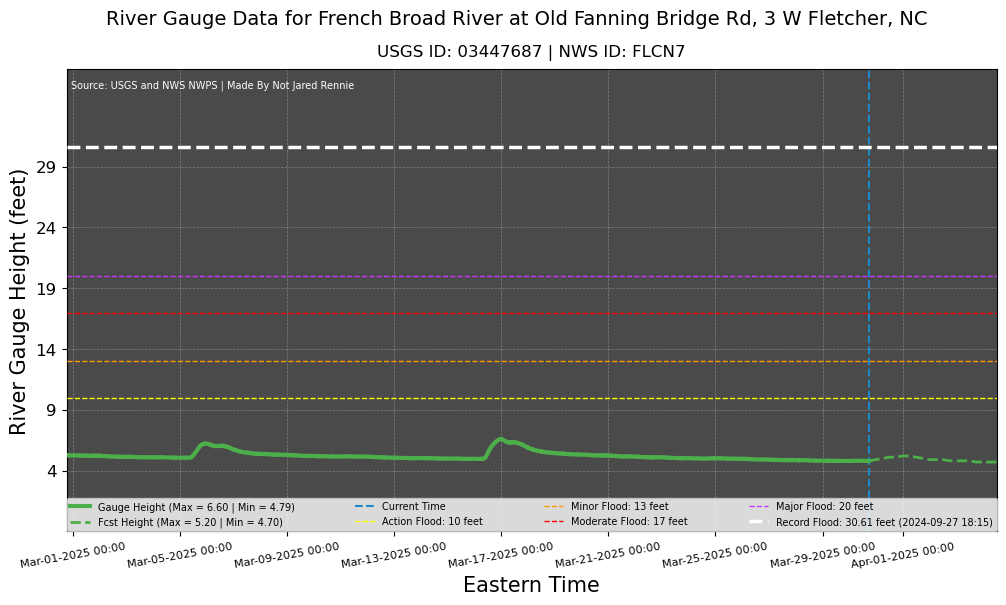

In [9]:
############################################################
# PLOT
dpi=100
fig, ax1 = plt.subplots(figsize=(12, 6), edgecolor='white', facecolor='white', dpi=dpi)

# Add grid lines
plt.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
ax1.set_facecolor('#4a4a4a')

# Plot X Limits
xMin=outData['validTimeLocal'].values[0]
xMax=outData['validTimeLocal'].values[-1]

# Plot Y Limits
ymin=min(int(1 * round(float((min(outData['primary'].values) - 1))/1)),9999)
if hasRecord:
    ymax=max(int(1 * round(float((stationRecordVal + 1))/1)),-9999)
elif hasMajor:
    ymax=max(int(1 * round(float((stationMajor + 1))/1)),-9999)
elif hasModerate:
    ymax=max(int(1 * round(float((stationModerate + 1))/1)),-9999)
elif hasMinor:
    ymax=max(int(1 * round(float((stationMinor + 1))/1)),-9999)
elif hasAction:
    ymax=max(int(1 * round(float((stationAction + 1))/1)),-9999)
else:
    ymax=max(int(1 * round(float((max(outData['primary'].values) - 1))/1)),9999)
plt.ylim((ymin-5), (ymax+5))

# Plot Data
plt.plot(outDataObs['validTimeLocal'].values, outDataObs['primary'].values, linewidth=3, color='#4daf4a', label="Gauge Height (Max = "+str(dataObsMax)+" | Min = "+str(dataObsMin)+")",zorder=10)
if hasFcst:
    plt.plot(outDataFcst['validTimeLocal'].values, outDataFcst['primary'].values, linewidth=2,linestyle='dashed', color='#4daf4a', label="Fcst Height (Max = "+str(dataFcstMax)+" | Min = "+str(dataFcstMin)+")",zorder=10)
    plt.vlines(outDataFcst['validTimeLocal'].values[0],ymin-5,ymax+5,colors='#1d89cb',linewidth=1.5, linestyles='dashed',label='Current Time',zorder=9)

# Plot Flood Thresholds
if hasAction:
    plt.hlines(float(stationAction),xMin,xMax,colors='#feff03',linewidth=1, linestyles='dashed',label="Action Flood: "+str(stationAction)+' feet',zorder=9)
if hasMinor:
    plt.hlines(float(stationMinor),xMin,xMax,colors='#fe9804',linewidth=1, linestyles='dashed',label="Minor Flood: "+str(stationMinor)+' feet',zorder=9)
if hasModerate:
    plt.hlines(float(stationModerate),xMin,xMax,colors='#fe0200',linewidth=1, linestyles='dashed',label="Moderate Flood: "+str(stationModerate)+' feet',zorder=9)
if hasMajor:
    plt.hlines(float(stationMajor),xMin,xMax,colors='#cc33ff',linewidth=1, linestyles='dashed',label="Major Flood: "+str(stationMajor)+' feet',zorder=9)
if hasRecord:
    plt.hlines(float(stationRecordVal),xMin,xMax,colors='white',linewidth=2.5, linestyles='dashed',label="Record Flood: "+str(stationRecordVal)+' feet '+'('+(stationRecordDate2)+')',zorder=9)

# Plot Legend
plt.legend(loc=3, ncol=4, mode="expand", borderaxespad=0., fontsize=7).set_zorder(102)

# Plot Y-Axis Label
plt.yticks(range(ymin, ymax, 5), [r'{}'.format(x) for x in range(ymin, ymax, 5)], fontsize=12, color='black')
plt.ylabel(r'River Gauge Height (feet)', fontsize=15, color='black')

# Plot X Limits
plt.xlim(xMin, xMax)

# Plot X-Axis Label
dateFmt = mdates.DateFormatter('%b-%d-%Y %H:%M')
ax1.xaxis.set_major_formatter(dateFmt)
ax1.tick_params(axis='x', labelrotation=10,labelsize=8)
plt.xlabel(stnTZName2, fontsize=15, color='black')

# Plot Title/Subtitle
plt.suptitle('River Gauge Data for '+sationNameFull, fontsize=14, color='black')
plt.title('USGS ID: '+str(stationIDusgs)+' | NWS ID: '+str(stationIDnws),fontsize=12,color='black',y=1.01)
plt.annotate('Source: USGS and NWS NWPS | Made By '+author,xy=(0.005, 0.955), xycoords='axes fraction', fontsize=7,horizontalalignment='left', verticalalignment='bottom', color='white')

plt.show()

## Get Historical Data from USGS NWIS
This is great so far, but NWPS only has the last 30 days of data. What if we wanted to go farther back in time? Well that is where we go to the USGS API.

Here, we have to use the USGS ID, but the NWPS API already figure dout what it was, so use that. Also, we need to define a start and end date. Otherwise it may take the entire period of record, which could take time.

In [10]:
# Derine station (USGS ID needed here, but we already captured it)
site=stationIDusgs

# Define Start and End Date
startDate='2024-09-20'
endDate='2024-10-05'
print(site,startDate,endDate)

03447687 2024-09-20 2024-10-05


The NWIS API from USGS is slightly different, but we are using the 'dataretrieval' python package to do most of the heavy lifting. Here we want 'instantaneous values' of river gauge height (parameter number 00065). We also need to convert UTC time to Local Time.

In [11]:
# Get Data from NWIS API
inService='iv'    # iv = instantaneous values (sub hourly) | dv = daily values
parameter='00065' # River Gauge Height
stnData = nwis.get_record(sites=site,service=inService,start=startDate, end=endDate, parameterCd=parameter).reset_index()

# Get Stats
stnDataMax=stnData[parameter].max()
stnDataMin=stnData[parameter].min()

# Deal with Time Zones
stnData["validTimeUTC"] = pd.to_datetime(stnData["datetime"])
stnData["validTimeLocal"] = pd.to_datetime(stnData["datetime"]).dt.tz_convert(convertTZ)

stnData

,datetime,site_no,00065,00065_cd,validTimeUTC,validTimeLocal
0,2024-09-20 04:00:00+00:00,03447687,4.54,P,2024-09-20 04:00:00+00:00,2024-09-20 00:00:00-04:00
1,2024-09-20 04:15:00+00:00,03447687,4.54,P,2024-09-20 04:15:00+00:00,2024-09-20 00:15:00-04:00
2,2024-09-20 04:30:00+00:00,03447687,4.54,P,2024-09-20 04:30:00+00:00,2024-09-20 00:30:00-04:00
3,2024-09-20 04:45:00+00:00,03447687,4.53,P,2024-09-20 04:45:00+00:00,2024-09-20 00:45:00-04:00
4,2024-09-20 05:00:00+00:00,03447687,4.53,P,2024-09-20 05:00:00+00:00,2024-09-20 01:00:00-04:00
...,...,...,...,...,...,...
1531,2024-10-06 02:45:00+00:00,03447687,6.40,P,2024-10-06 02:45:00+00:00,2024-10-05 22:45:00-04:00
1532,2024-10-06 03:00:00+00:00,03447687,6.39,P,2024-10-06 03:00:00+00:00,2024-10-05 23:00:00-04:00
1533,2024-10-06 03:15:00+00:00,03447687,6.39,P,2024-10-06 03:15:00+00:00,2024-10-05 23:15:00-04:00
1534,2024-10-06 03:30:00+00:00,03447687,6.38,P,2024-10-06 03:30:00+00:00,2024-10-05 23:30:00-04:00


In [12]:
# Output to CSV
csvFile='nwps_gauge_'+str(stationID)+'_'+startDate.replace('-','')+'-'+endDate.replace('-','')+'.csv'
stnData.to_csv(csvFile,index = False)
print('OUTPUTTING TO CSV: ',csvFile)

OUTPUTTING TO CSV:  nwps_gauge_FLCN7_20240920-20241005.csv


Now we plot again (note that there is no forecast data here).

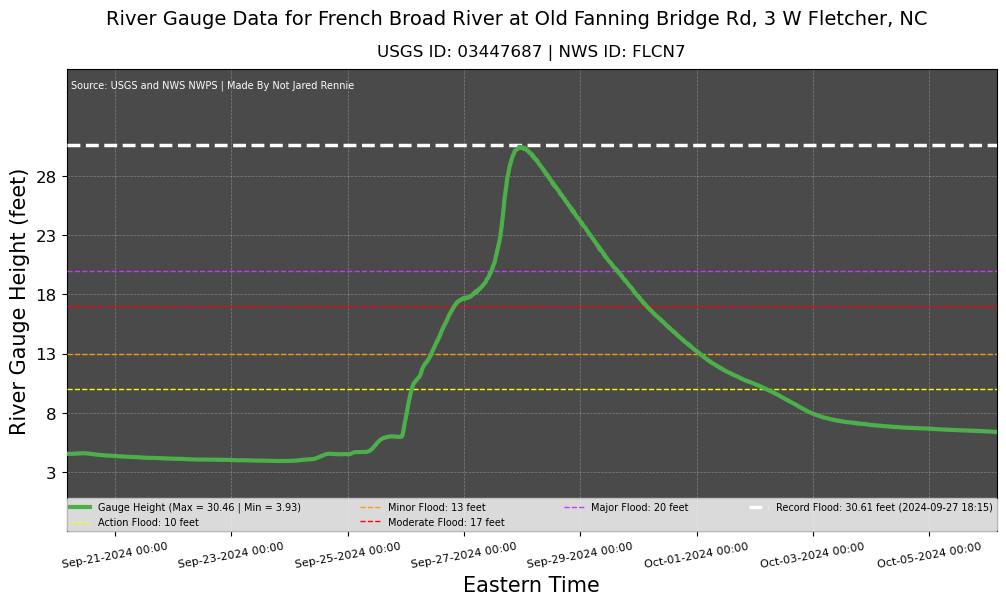

In [13]:
############################################################
# PLOT
dpi=100
fig, ax1 = plt.subplots(figsize=(12, 6), edgecolor='white', facecolor='white', dpi=dpi)

# Add grid lines
plt.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
ax1.set_facecolor('#4a4a4a')

# Plot X Limits
xMin=stnData['validTimeLocal'].values[0]
xMax=stnData['validTimeLocal'].values[-1]

# Plot Y Limits
ymin=min(int(1 * round(float((min(stnData[parameter].values) - 1))/1)),9999)
if hasRecord:
    ymax=max(int(1 * round(float((stationRecordVal + 1))/1)),-9999)
elif hasMajor:
    ymax=max(int(1 * round(float((stationMajor + 1))/1)),-9999)
elif hasModerate:
    ymax=max(int(1 * round(float((stationModerate + 1))/1)),-9999)
elif hasMinor:
    ymax=max(int(1 * round(float((stationMinor + 1))/1)),-9999)
elif hasAction:
    ymax=max(int(1 * round(float((stationAction + 1))/1)),-9999)
else:
    ymax=max(int(1 * round(float((max(stnData[parameter].values) + 1))/1)),-9999)
plt.ylim((ymin-5), (ymax+5))

# Plot Data
plt.plot(stnData['validTimeLocal'].values, stnData[parameter].values, linewidth=3, color='#4daf4a', label="Gauge Height (Max = "+str(stnDataMax)+" | Min = "+str(stnDataMin)+")",zorder=10)

# Plot Flood Thresholds
if hasAction:
    plt.hlines(float(stationAction),xMin,xMax,colors='#feff03',linewidth=1, linestyles='dashed',label="Action Flood: "+str(stationAction)+' feet',zorder=9)
if hasMinor:
    plt.hlines(float(stationMinor),xMin,xMax,colors='#fe9804',linewidth=1, linestyles='dashed',label="Minor Flood: "+str(stationMinor)+' feet',zorder=9)
if hasModerate:
    plt.hlines(float(stationModerate),xMin,xMax,colors='#fe0200',linewidth=1, linestyles='dashed',label="Moderate Flood: "+str(stationModerate)+' feet',zorder=9)
if hasMajor:
    plt.hlines(float(stationMajor),xMin,xMax,colors='#cc33ff',linewidth=1, linestyles='dashed',label="Major Flood: "+str(stationMajor)+' feet',zorder=9)
if hasRecord:
    plt.hlines(float(stationRecordVal),xMin,xMax,colors='white',linewidth=2.5, linestyles='dashed',label="Record Flood: "+str(stationRecordVal)+' feet '+'('+(stationRecordDate2)+')',zorder=9)

# Plot Legend
plt.legend(loc=3, ncol=4, mode="expand", borderaxespad=0., fontsize=7).set_zorder(102)

# Plot Y-Axis Label
plt.yticks(range(ymin, ymax, 5), [r'{}'.format(x) for x in range(ymin, ymax, 5)], fontsize=12, color='black')
plt.ylabel(r'River Gauge Height (feet)', fontsize=15, color='black')

# Plot X Limits
plt.xlim(xMin, xMax)

# Plot X-Axis Label
dateFmt = mdates.DateFormatter('%b-%d-%Y %H:%M')
ax1.xaxis.set_major_formatter(dateFmt)
ax1.tick_params(axis='x', labelrotation=10,labelsize=8)
plt.xlabel(stnTZName2, fontsize=15, color='black')

# Plot Title/Subtitle
plt.suptitle('River Gauge Data for '+sationNameFull, fontsize=14, color='black')
plt.title('USGS ID: '+str(stationIDusgs)+' | NWS ID: '+str(stationIDnws),fontsize=12,color='black',y=1.01)
plt.annotate('Source: USGS and NWS NWPS | Made By '+author,xy=(0.005, 0.955), xycoords='axes fraction', fontsize=7,horizontalalignment='left', verticalalignment='bottom', color='white')

plt.show()

## Get Metadata and Data (Multiple Stations)
We now return to NWPS to get a snapshot of current flooding for the United States. First we have to gather stations for the US, including OCONUS areas such as Alaska, Hawaii, and Puerto Rico. Note that this is a big request to the API, and may take a couple of times before a successful grab.

If you continue to get API Errors, try and get a smaller subset of stations by changing the bounding box.

In [18]:
%%time
# Get Bounding Box
xmin='-179.1'; ymin='17.9'; xmax='-65.2'; ymax='71.4'  # Entire US (including CONUS and AK/HI/PR)
#xmin='-125.0'; ymin='24.5'; xmax='-66.9'; ymax='49.4'  # Lower 48 States Only
#xmin='-95.0'; ymin='24.5'; xmax='-73.0'; ymax='40.0'  # Southeast Subset

# API URL
url='https://api.water.noaa.gov/nwps/v1/gauges?bbox.xmin='+xmin+'&bbox.ymin='+ymin+'&bbox.xmax='+xmax+'&bbox.ymax='+ymax+'&srid=EPSG_4326'

# Make the request
response = requests.get(url)

# Check if request was successful
if response.status_code == 200:
    multData = response.json()  # Convert response to JSON
    print('SUCCESS!')
    print('NUM STNS: ',len(multData['gauges']))
else:
    print(f"API Error: {response.status_code}")

# Get Current Time
currTime = datetime.datetime.now(pytz.utc)
currTime = pd.to_datetime(currTime).strftime('%Y%m%d-%H%MUTC')
currTimeUTC = datetime.datetime.now(pytz.utc)
currTimeUTC= pd.to_datetime(currTimeUTC).strftime('%Y-%m-%d %H:%M UTC')

SUCCESS!
NUM STNS:  11783
CPU times: user 149 ms, sys: 29.5 ms, total: 178 ms
Wall time: 52.3 s


Parse out the relevant metadata/data info into a Pandas Dataframe

In [19]:
%%time

# Run Through Each Station
data_counter=0
for data in multData['gauges']:    
    # Extract relevant fields
    extracted_data = {
        # Metadata
        "NWS ID": data.get("lid"),
        "Name": data.get("name"),
        "State": data["state"].get("abbreviation") if "state" in data else None,
        "Latitude": data.get("latitude"),
        "Longitude": data.get("longitude"),
        "RFC": data["rfc"].get("abbreviation") if "rfc" in data else None,
        "WFO": data["wfo"].get("abbreviation") if "wfo" in data else None,
        
        # Flooding Info
        "Gauge Height": data["status"]["observed"].get("primary") if "status" in data else None,
        "Flood Info": data["status"]["observed"].get("floodCategory") if "status" in data else None,
        "Fcst Info": data["status"]["forecast"].get("floodCategory") if "status" in data else None,
    }
    df = pd.DataFrame([extracted_data]) 
    if data_counter==0:
        outStnMeta = df
    else:
        outStnMeta = pd.concat([outStnMeta, df], ignore_index=True)
    data_counter+=1
outStnMeta

CPU times: user 15.1 s, sys: 0 ns, total: 15.1 s
Wall time: 15.1 s


,NWS ID,Name,State,Latitude,Longitude,RFC,WFO,Gauge Height,Flood Info,Fcst Info
0,AACS2,Cheyenne River above Angostura at Hwy 71,SD,43.305770,-103.562797,MBRFC,UNR,3200.28,no_flooding,fcst_not_current
1,AAIT2,Williamson Creek at Manchaca Road at Austin,TX,30.221111,-97.793333,WGRFC,EWX,1.92,no_flooding,fcst_not_current
2,AAKA2,Antler River below Antler Lake near Auke Bay,AK,58.851944,-134.708611,APRFC,AJK,29.19,no_flooding,fcst_not_current
3,AAMC1,San Francisco Bay Alameda tide gage,CA,37.771667,-122.298333,CNRFC,MTR,4.36,not_defined,fcst_not_current
4,AANG1,Peachtree Creek at Atlanta,GA,33.820306,-84.407639,SERFC,FFC,2.52,no_flooding,fcst_not_current
...,...,...,...,...,...,...,...,...,...,...
11778,ZSRM2,Zekiah Swamp Run near Newtown,MD,38.490556,-76.927222,MARFC,LWX,1.37,no_flooding,fcst_not_current
11779,ZTNK2,Pennsylvania Run near Zoneton,KY,38.087500,-85.642500,OHRFC,LMK,1.40,not_defined,fcst_not_current
11780,ZUIN5,Zuni River above Black Rock Reservoir,NM,35.100278,-108.751667,CBRFC,ABQ,1.34,no_flooding,no_flooding
11781,ZUMM5,Zumbro River at Zumbro Falls,MN,44.285600,-92.430000,NCRFC,ARX,6.47,no_flooding,fcst_not_current


We only want current gauge info that is reporting properly. Some sites (for example, Alaska) don't operate year round.

In [20]:
# Only Use Current Stations Reporting
flood_categories=['no_flooding','action','minor','moderate','major']
outStnMeta=outStnMeta[outStnMeta['Flood Info'].isin(flood_categories)]

outStnMeta

,NWS ID,Name,State,Latitude,Longitude,RFC,WFO,Gauge Height,Flood Info,Fcst Info
0,AACS2,Cheyenne River above Angostura at Hwy 71,SD,43.305770,-103.562797,MBRFC,UNR,3200.28,no_flooding,fcst_not_current
1,AAIT2,Williamson Creek at Manchaca Road at Austin,TX,30.221111,-97.793333,WGRFC,EWX,1.92,no_flooding,fcst_not_current
2,AAKA2,Antler River below Antler Lake near Auke Bay,AK,58.851944,-134.708611,APRFC,AJK,29.19,no_flooding,fcst_not_current
4,AANG1,Peachtree Creek at Atlanta,GA,33.820306,-84.407639,SERFC,FFC,2.52,no_flooding,fcst_not_current
5,ABAG1,Alabaha River at GA Highway 203 near Blackshear,GA,31.375278,-82.288889,SERFC,JAX,5.41,no_flooding,fcst_not_current
...,...,...,...,...,...,...,...,...,...,...
11777,ZPHF1,Hillsborough River near Zephyrhills at State Park,FL,28.149722,-82.231944,SERFC,TBW,1.20,no_flooding,fcst_not_current
11778,ZSRM2,Zekiah Swamp Run near Newtown,MD,38.490556,-76.927222,MARFC,LWX,1.37,no_flooding,fcst_not_current
11780,ZUIN5,Zuni River above Black Rock Reservoir,NM,35.100278,-108.751667,CBRFC,ABQ,1.34,no_flooding,no_flooding
11781,ZUMM5,Zumbro River at Zumbro Falls,MN,44.285600,-92.430000,NCRFC,ARX,6.47,no_flooding,fcst_not_current


### Output to CSV
Let's output the data to a CSV file so you can load it and play with it elsewhere.

In [21]:
outFile='nwps_current_'+str(currTime)+'.csv'
outStnMeta.to_csv(outFile,index = False)
print('SUCCESS! RESULTS IN: ',outFile)

SUCCESS! RESULTS IN:  nwps_current_20250330-1907UTC.csv


Now back to the good part!

## Plot Current Station Status on a Map
We import some map plotting packagaes and plot. Note this might take some time (and a Download warning may pop up).

PLOTTING OBSERVED STATUS


/opt/conda/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


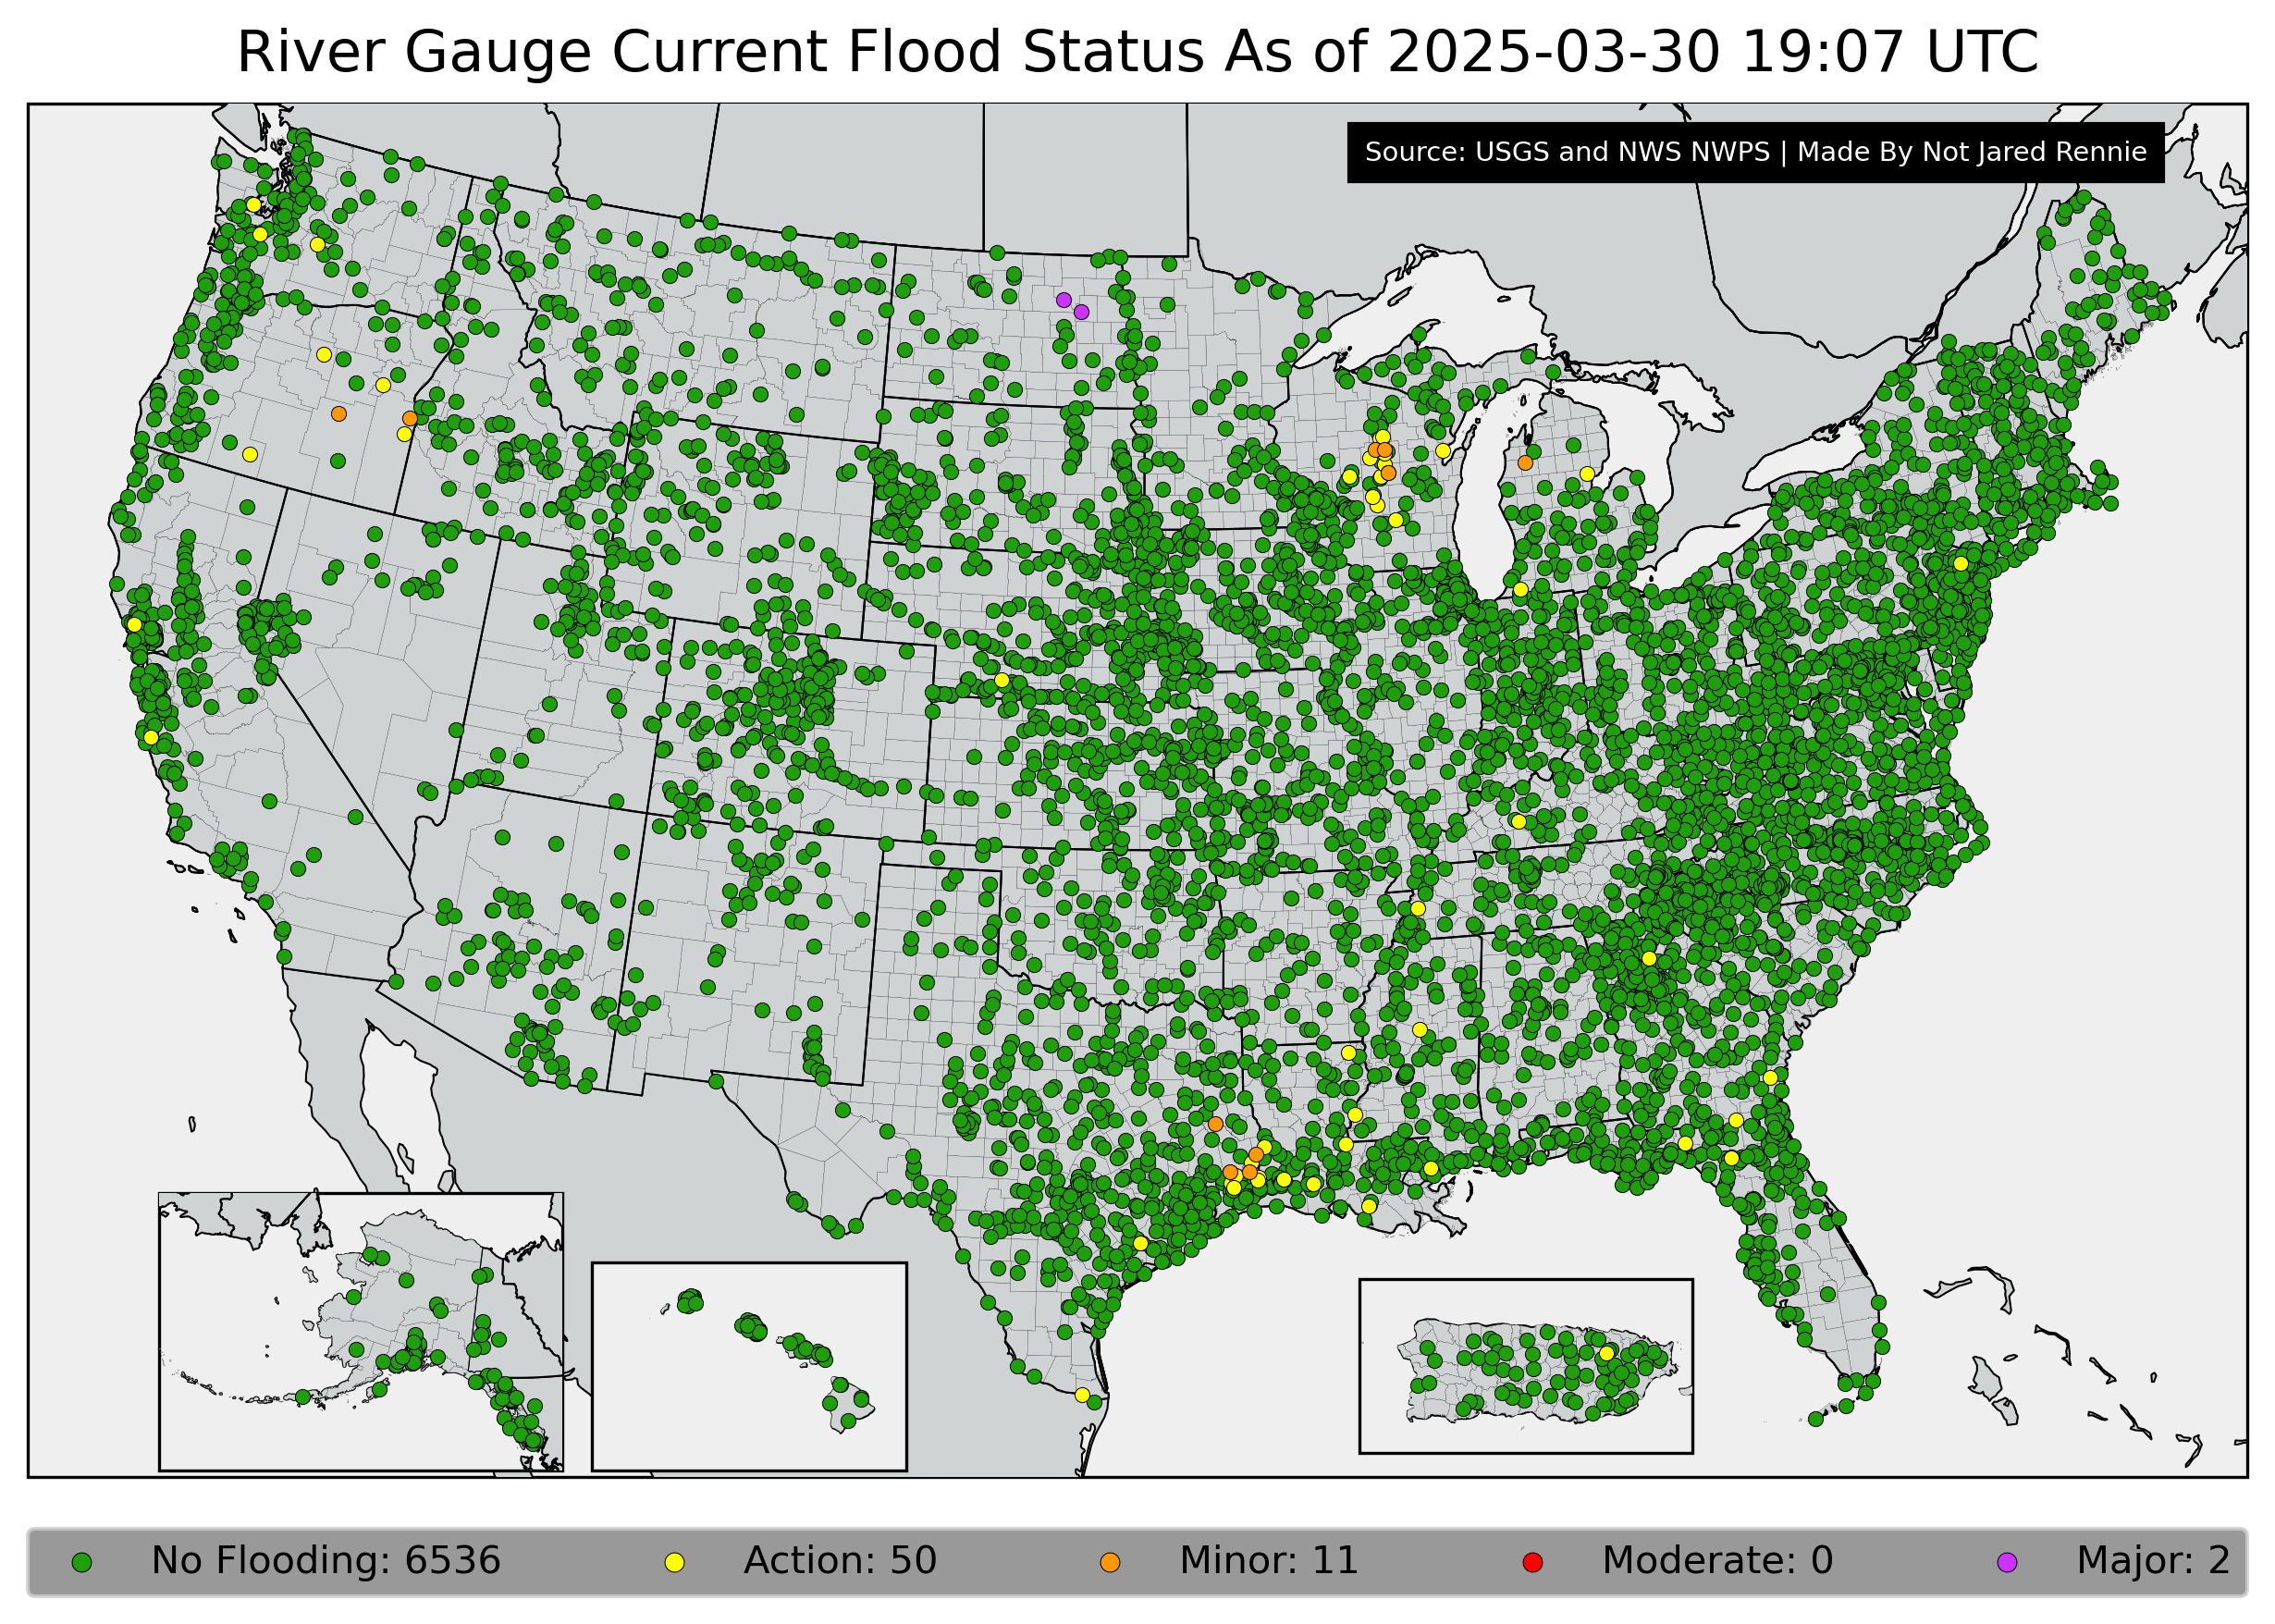

CPU times: user 3min 14s, sys: 1.42 s, total: 3min 15s
Wall time: 3min 18s


In [22]:
%%time
#################################################
# Plot All Stages (Observed)
print('PLOTTING OBSERVED STATUS')

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES

# Plotting Parameters
dpi=300
land_hex='#cfd3d4'  # ESRI Light Gray Canvas
ocean_hex='#efefef' # ESRI Light Gray Canvas
edgecolor='black'

# Set Up Figure
fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')

# CONUS AXES
conus_ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
conus_ax.set_facecolor(ocean_hex)
conus_ax.spines['geo'].set_edgecolor(edgecolor)
conus_ax.set_extent([-120, -73, 22, 50], crs=ccrs.Geodetic())

# ALASKA AXES
ak_ax = fig.add_axes([0.05, 0.01, 0.20, 0.20], projection=ccrs.Orthographic(central_longitude=-133.66666667, central_latitude=57.00000000))
ak_ax.set_facecolor(ocean_hex)
ak_ax.spines['geo'].set_edgecolor(edgecolor)
ak_ax.set_extent([-184, -128, 67, 53], crs=ccrs.Geodetic())

# HAWAII AXES
hi_ax = fig.add_axes([0.25, 0.01, 0.15, 0.15], projection=ccrs.Mercator())
hi_ax.set_facecolor(ocean_hex)
hi_ax.spines['geo'].set_edgecolor(edgecolor)
hi_ax.set_extent([-162, -154, 18, 23], crs=ccrs.Geodetic())

# PUERTO RICO AXES
pr_ax = fig.add_axes([0.60, 0.01, 0.15, 0.15], projection=ccrs.Mercator())
pr_ax.set_facecolor(ocean_hex)
pr_ax.spines['geo'].set_edgecolor(edgecolor)
pr_ax.set_extent([-67.5, -65.5, 17.75, 18.75], crs=ccrs.Geodetic())

# Add other Features
conus_ax.add_feature(cfeature.LAND,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=3)
conus_ax.add_feature(cfeature.LAKES,linewidth=0.5,facecolor=ocean_hex,edgecolor=edgecolor,zorder=4)
conus_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
conus_ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor=edgecolor,zorder=10)
conus_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

ak_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
ak_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

hi_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
hi_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

pr_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
pr_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

# Plot Points
stages=flood_categories
colors=['#1f9f0c','#feff03','#fe9804','#fe0200','#cc33ff']
totalFloody=0
color_counter=0
for stage in stages:
    floodyData=outStnMeta[outStnMeta['Flood Info'] ==stage]
    numFloody=len(floodyData['NWS ID'].unique())
    totalFloody=totalFloody+numFloody

    outLats=floodyData['Latitude'].values
    outLons=floodyData['Longitude'].values
    outStates=floodyData['State'].values
    outColor=colors[color_counter]

    # Add some dummy data (for labels)
    if stage == 'No_Flooding' or stage =='no_flooding':
        stage = 'No Flooding'
    conus_ax.scatter(0, 0, marker='o',s=25,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10,label=str(stage.title())+': '+str(numFloody))

    # Add Actual Data
    for counter in range(0,len(outLats)):
        lat=outLats[counter]
        lon=outLons[counter]
        st=outStates[counter].upper()
        if st =='AK':
            ak_ax.scatter(lon, lat, marker='o',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10)
        elif st =='HI':
            hi_ax.scatter(lon, lat, marker='o',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10)
        elif st == 'PR':
            pr_ax.scatter(lon, lat, marker='o',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10)
        else:
            conus_ax.scatter(lon, lat, marker='o',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=100)
    color_counter+=1
    
# Add Legend
conus_ax.legend(bbox_to_anchor=(0., -.087, 1., -1.02), loc=3, ncol=5, mode="expand", borderaxespad=0., fontsize=10, facecolor='#808080')

# Add Titles
plt.suptitle('River Gauge Current Flood Status As of '+currTimeUTC,size=15,color='black',y=1.05) 
conus_ax.annotate('Source: USGS and NWS NWPS | Made By '+author,xy=(0.955, 0.955), xycoords='axes fraction', fontsize=7,backgroundcolor='black',color='white',horizontalalignment='right', verticalalignment='bottom',zorder=10)

# Show Plot
plt.show()

Cool, but this is observed, what is the forecast?

## Plot Forecast Station Status on a Map
Note that not all stations that observe flooding have forecasting info.

In [23]:
# Only Use Forecast Stations Reporting
flood_categories=['no_flooding','action','minor','moderate','major']
outStnMeta=outStnMeta[outStnMeta['Fcst Info'].isin(flood_categories)]

outStnMeta

,NWS ID,Name,State,Latitude,Longitude,RFC,WFO,Gauge Height,Flood Info,Fcst Info
11,ABDM6,Buttahatchie River near Aberdeen,MS,33.790000,-88.315278,SERFC,MEG,8.41,no_flooding,minor
12,ABEM6,Tombigbee River at Aberdeen Lock and Dam,MS,33.830000,-88.520000,SERFC,MEG,163.22,no_flooding,no_flooding
19,ABNG1,Flint River (GA) at Albany,GA,31.594167,-84.144167,SERFC,TAE,5.03,no_flooding,no_flooding
20,ABOM8,Clark Fork River above Missoula,MT,46.877222,-113.931389,NWRFC,MSO,3.22,no_flooding,no_flooding
24,ABQN5,Rio Grande at Albuquerque,NM,35.089167,-106.680556,WGRFC,ABQ,2.92,no_flooding,no_flooding
...,...,...,...,...,...,...,...,...,...,...
11756,YWPC1,Feather River at Yuba City Water Treatment Plant,CA,39.161648,-121.612419,CNRFC,STO,44.88,no_flooding,no_flooding
11758,YZOM6,Yazoo River at Yazoo City,MS,32.857900,-90.436800,LMRFC,JAN,23.43,no_flooding,no_flooding
11761,ZANO1,Muskingum River at Zanesville,OH,39.938889,-82.012500,OHRFC,PBZ,9.63,no_flooding,no_flooding
11774,ZONI3,Eagle Creek (IN) at Zionsville,IN,39.946389,-86.260278,OHRFC,IND,1.70,no_flooding,no_flooding


PLOTTING FORECAST STATUS


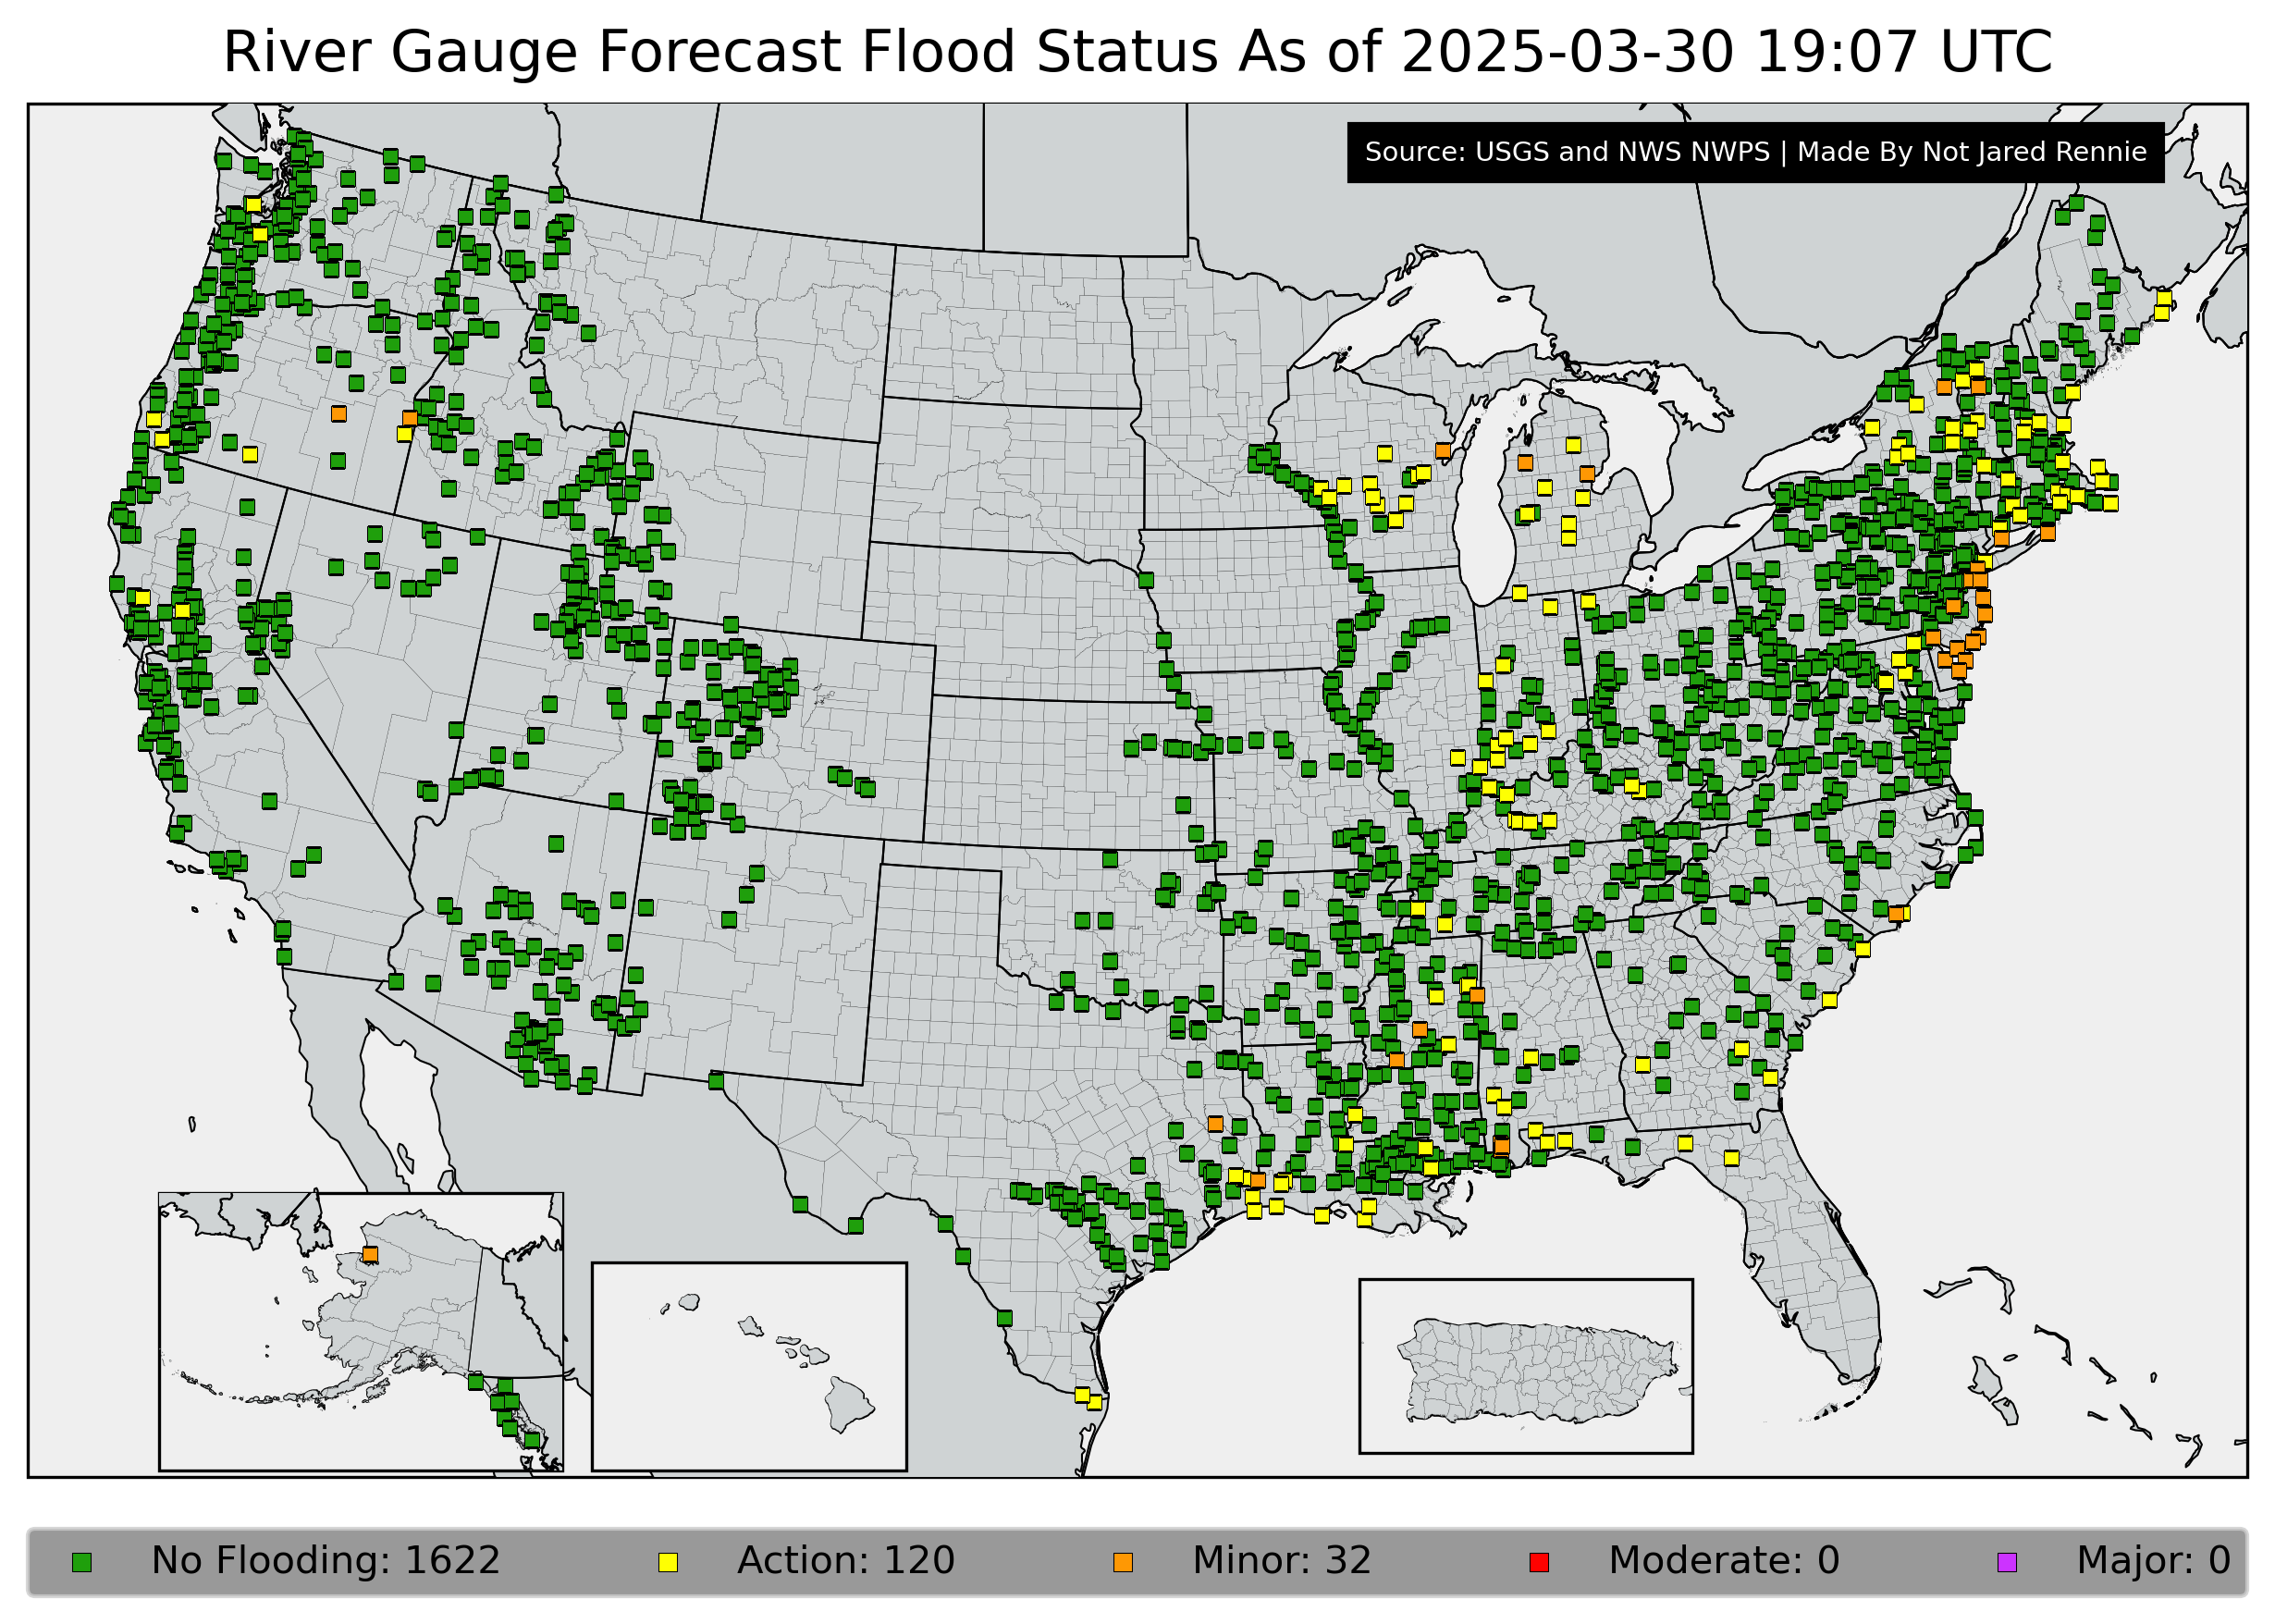

CPU times: user 2min 20s, sys: 350 ms, total: 2min 20s
Wall time: 2min 20s


In [24]:
%%time
#################################################
# Plot All Stages (Forecast)
print('PLOTTING FORECAST STATUS')

# Set Up Figure
fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')

# CONUS AXES
conus_ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
conus_ax.set_facecolor(ocean_hex)
conus_ax.spines['geo'].set_edgecolor(edgecolor)
conus_ax.set_extent([-120, -73, 22, 50], crs=ccrs.Geodetic())

# ALASKA AXES
ak_ax = fig.add_axes([0.05, 0.01, 0.20, 0.20], projection=ccrs.Orthographic(central_longitude=-133.66666667, central_latitude=57.00000000))
ak_ax.set_facecolor(ocean_hex)
ak_ax.spines['geo'].set_edgecolor(edgecolor)
ak_ax.set_extent([-184, -128, 67, 53], crs=ccrs.Geodetic())

# HAWAII AXES
hi_ax = fig.add_axes([0.25, 0.01, 0.15, 0.15], projection=ccrs.Mercator())
hi_ax.set_facecolor(ocean_hex)
hi_ax.spines['geo'].set_edgecolor(edgecolor)
hi_ax.set_extent([-162, -154, 18, 23], crs=ccrs.Geodetic())

# PUERTO RICO AXES
pr_ax = fig.add_axes([0.60, 0.01, 0.15, 0.15], projection=ccrs.Mercator())
pr_ax.set_facecolor(ocean_hex)
pr_ax.spines['geo'].set_edgecolor(edgecolor)
pr_ax.set_extent([-67.5, -65.5, 17.75, 18.75], crs=ccrs.Geodetic())

# Add other Features
conus_ax.add_feature(cfeature.LAND,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=3)
conus_ax.add_feature(cfeature.LAKES,linewidth=0.5,facecolor=ocean_hex,edgecolor=edgecolor,zorder=4)
conus_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
conus_ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor=edgecolor,zorder=10)
conus_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

ak_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
ak_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

hi_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
hi_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

pr_ax.add_feature(cfeature.STATES,linewidth=0.5,facecolor=land_hex,edgecolor=edgecolor,zorder=5)
pr_ax.add_feature(USCOUNTIES.with_scale('500k'),linewidth=0.05,edgecolor='black',facecolor=land_hex,zorder=9)

# Plot Points
stages=flood_categories
colors=['#1f9f0c','#feff03','#fe9804','#fe0200','#cc33ff']
totalFloody=0
color_counter=0
for stage in stages:
    floodyData=outStnMeta[outStnMeta['Fcst Info'] ==stage]
    numFloody=len(floodyData['NWS ID'].unique())
    totalFloody=totalFloody+numFloody

    outLats=floodyData['Latitude'].values
    outLons=floodyData['Longitude'].values
    outStates=floodyData['State'].values
    outColor=colors[color_counter]

    # Add some dummy data (for labels)
    if stage == 'No_Flooding' or stage =='no_flooding':
        stage = 'No Flooding'
    conus_ax.scatter(0, 0, marker='s',s=25,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10,label=str(stage.title())+': '+str(numFloody))

    # Add Actual Data
    for counter in range(0,len(outLats)):
        lat=outLats[counter]
        lon=outLons[counter]
        st=outStates[counter].upper()
        if st =='AK':
            ak_ax.scatter(lon, lat, marker='s',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10)
        elif st =='HI':
            hi_ax.scatter(lon, lat, marker='s',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10)
        elif st == 'PR':
            pr_ax.scatter(lon, lat, marker='s',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=10)
        else:
            conus_ax.scatter(lon, lat, marker='s',s=15,color=outColor,edgecolors='black',linewidths=0.25,transform=ccrs.PlateCarree(),zorder=100)
    color_counter+=1
    
# Add Legend
conus_ax.legend(bbox_to_anchor=(0., -.087, 1., -1.02), loc=3, ncol=5, mode="expand", borderaxespad=0., fontsize=10, facecolor='#808080')

# Add Titles
plt.suptitle('River Gauge Forecast Flood Status As of '+currTimeUTC,size=15,color='black',y=1.05) 
conus_ax.annotate('Source: USGS and NWS NWPS | Made By '+author,xy=(0.955, 0.955), xycoords='axes fraction', fontsize=7,backgroundcolor='black',color='white',horizontalalignment='right', verticalalignment='bottom',zorder=10)

# Show Plot
plt.show()

Isn't it beautiful? Congrats! You made a spatial plot! Feel free to post on social media for the world to see!

Congrats on completing this notebook! Now go forth and make better plots!